In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter as gf
from skimage.draw import line_aa as line
from skimage import color



%matplotlib inline

## Create the fascicles

In [2]:
def create_waves():
    # This function creates a pattern that looks similar to the parallel lines in the upper half of your images
        
    # Create a basic meshgrid
    vec          = np.linspace(0,1,512)
    YY,XX        = np.meshgrid(vec,vec)
    
    # High frequency noise
    noise        = np.random.randn(512,512)
    noise        = gf(noise,sigma=30)
    noise_high   = noise/np.std(noise)
    
    # Low frequency noise
    noise        = np.random.randn(512,512)
    noise        = gf(noise,sigma=95)
    noise_low    = noise/np.std(noise)
    
    # Adding noise waves to images
    wave         = 0.25*XX + 0.05*YY*(1+np.random.random(1)) # make the angles of the lines a bit random
    wave        += 0.0008*(noise_low + noise_high)
    
    # Make waves binary (this just makes it looks nicer)
    wave         = (np.sin(wave*500*np.pi)>0.55)*1.
    
    # Some of the waves must be removed    
    mask         = np.random.randn(512,512)
    mask         = gf(mask,sigma=20)
    mask         = (mask/np.std(mask) > 0)*1.
        
    # Mask the waves
    wave         = wave * mask
    
    # Make it an RGB image
    wave         = np.tile(np.expand_dims(wave, -1),[1,1,3])
    wave[:,:,:0] = 0
    
       
    return wave

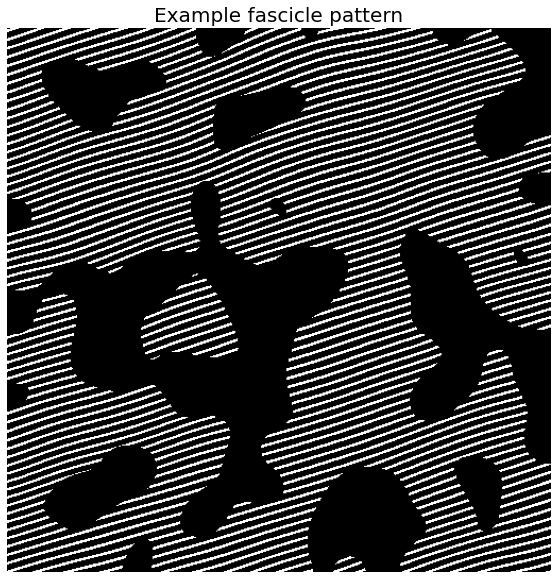

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(create_waves())
plt.title('Example fascicle pattern',fontsize=20)
plt.axis('off')
plt.show()

## Create the two aponeuroses

In [4]:
def create_lines():
    # This function creates the two big lines in the images
    lines = np.zeros((512,512,3))
    
    ## Upper line -----------------------------
    # Function describing the upper curve (simple 2nd order polynomial)
    u_var = 10
    x_u_0 = u_var + np.random.random(1)*u_var + 50
    x_u_1 = x_u_0 + u_var + np.random.random(1)*u_var
    x_u_2 = u_var + np.random.random(1)*u_var
    def f_u(x):
        return x_u_0 + (x_u_1-x_u_0)/512.*x + ((x-256)/512.)**2 * x_u_2
    
    # Create the coordinates
    x     = np.linspace(0,511,16).astype(np.int)
    y_u   = f_u(x)
    
    # Add the lines to image
    for i in range(1,x.shape[0]):
        rr,cc,_ = line(x[i-1],int(y_u[i-1]),x[i],int(y_u[i]))
        lines[cc,rr,0] = 1.
        
    ## Lower line -----------------------------
    # Function describing the lower curve (simple 2nd order polynomial)
    l_var = 10
    x_l_0 = l_var + np.random.random(1)*l_var + 250
    x_l_1 = x_l_0 + l_var*2 + np.random.random(1)*l_var
    x_l_2 = l_var + np.random.random(1)*l_var
    def f_l(x):
        return x_l_0 + (x_l_1-x_l_0)/512.*x + ((x-256)/512.)**2 * x_l_2
    
    # Create the coordinates
    y_l   = f_l(x)
    
    # Add the lines to image
    for i in range(1,x.shape[0]):
        rr,cc,_ = line(x[i-1],int(y_l[i-1]),x[i],int(y_l[i]))
        lines[cc,rr,1] = 1.
        
    # Blur the image (easy way of making the lines thicker)
    lines[:,:,0] = (gf(lines[:,:,0],sigma=3)>0.01)*1.
    lines[:,:,1] = (gf(lines[:,:,1],sigma=3)>0.01)*1.
    
    return lines

C:\Users\Paul\miniconda3\envs\SYN_IMGs\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


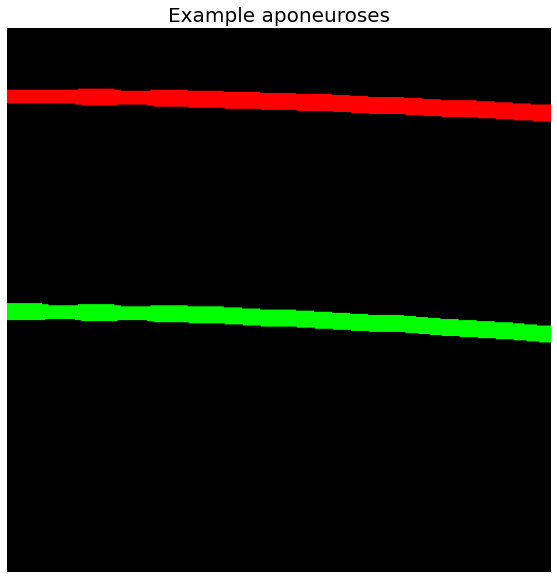

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(create_lines())
plt.title('Example aponeuroses',fontsize=20)
plt.axis('off')
plt.show()

## Merging both images together

In [6]:
def create_syn_image():
    # Create the primary structures
    lines = create_lines()
    waves = create_waves()
    
    # Create a mask for area between the two lines
    mask   = ((np.sum(lines,-1,keepdims=True) == 0)*255).astype(np.uint8)
    _,mask = cv2.connectedComponents(np.squeeze(mask))
    mask   = (mask == 2)*1.
    
    # Merge the two primary structures
    image  = lines + waves* np.expand_dims(mask,-1)
    
    # Add noise to create high entropy images
    noise  = np.random.random((512,512,3))
    image  = (1-image)*noise*0.3 + image*(1-0.1*noise) 
    
    return image

C:\Users\Paul\miniconda3\envs\SYN_IMGs\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


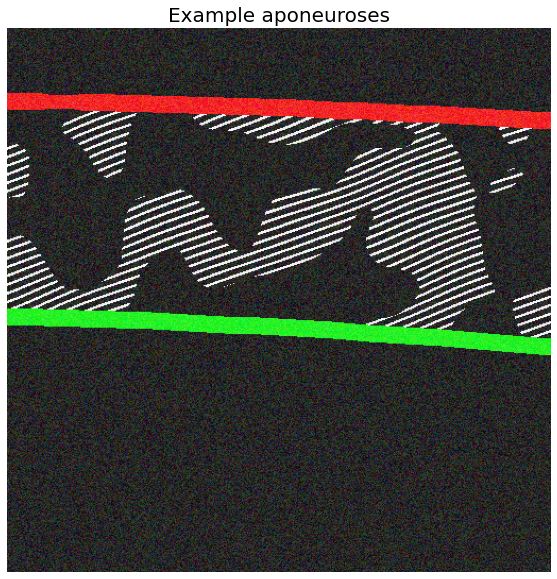

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(create_syn_image())
plt.title('Example aponeuroses',fontsize=20)
plt.axis('off')
plt.show()

In [8]:
# Generated images are essentially RGB, but grayscale are needed
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

## Create and save a single synthetic image

C:\Users\Paul\miniconda3\envs\SYN_IMGs\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


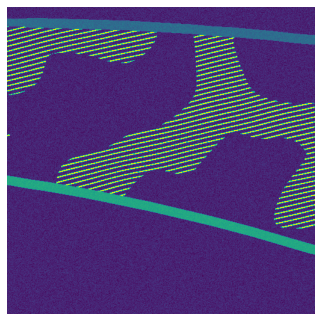

In [286]:
import cv2

my_dpi = 120 # https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels

fig = plt.figure(frameon=False)
fig.set_size_inches(512/my_dpi, 512/my_dpi)

img = create_syn_image()
img = rgb2gray(img)

# #plt.imshow(create_syn_image())

#plt.title('Example synthetic image',fontsize=20)
plt.axis('off')
plt.grid(False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(img)

# savename = 'synth_1' + '.tif'

# plt.savefig(savename, dpi=my_dpi)

plt.show()

#plt.close(fig)

## Create and save a batch of synthetic images

In [9]:
# Dots Per Inch on printed paper 
my_dpi = 120 # https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels

for im in range(0,20):
    
    fig = plt.figure(frameon=False)
    fig.set_size_inches(512/my_dpi, 512/my_dpi)

    img = create_syn_image()
    plt.axis('off')
    plt.grid(False)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    plt.imshow(img)

    savename = 'synth_' + str(im+50) + '.png'

    plt.savefig(savename, dpi=my_dpi)

    #plt.show()
    plt.close(fig)

C:\Users\Paul\miniconda3\envs\SYN_IMGs\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
